In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import numpy as np
import os
from glob import glob
import pandas as pd
import cv2
import albumentations as A
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from albumentations.pytorch import ToTensorV2
from torch import Tensor
import umap
from typing import Type

import random
# Train the ResNet18 model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(device)


2023-04-02 22:44:57.818053: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 22:44:58.632318: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/amir/.pyenv/versions/3.9.15/envs/uni/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/cuda/lib64
2023-04-02 22:44:58.632418: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/amir/.pyenv/ver

cpu


In [2]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.benchmark = True


In [27]:
from torchvision.datasets.utils import download_url
import tarfile
# Download the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
# download_url(dataset_url, '.')
# Extract from archive
# with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
#     tar.extractall(path='./data')

data_dir = './data/cifar10'

# print(os.listdir(data_dir))
classes = os.listdir(data_dir)
print(classes)


['dog', 'deer', 'airplane', 'cat', 'frog', 'truck', 'automobile', 'ship', 'horse', 'bird']


In [28]:
all_images = glob("data/cifar10/*/*.png")
data = []
for path in all_images:
    cls = path.split("/")[-2]
    data.append((cls, path))
df = pd.DataFrame(data, columns=["cls", "path"])

train_df = (
    df.groupby("cls")
    .apply(lambda x: x.sample(int(x.count() * 20 / 100)).path)
    .reset_index()
)
train_df = train_df.drop("level_1", axis=1)
test_df = df[~df.path.isin(train_df.path)]

print(len(train_df)/len(df)*100)


20.0


In [29]:
classes.index(train_df.iloc[0].cls)


2

In [30]:
test_df


,cls,path
0,dog,data/cifar10/dog/2218.png
1,dog,data/cifar10/dog/2922.png
2,dog,data/cifar10/dog/2887.png
3,dog,data/cifar10/dog/0255.png
4,dog,data/cifar10/dog/1410.png
...,...,...
59995,bird,data/cifar10/bird/3058.png
59996,bird,data/cifar10/bird/1987.png
59997,bird,data/cifar10/bird/3954.png
59998,bird,data/cifar10/bird/2857.png


In [31]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        cls = self.df.iloc[idx].cls

        img = cv2.imread(self.df.iloc[idx].path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transform:
            img = self.transform(image=img)["image"]

        cls_index = classes.index(cls)
        return img, cls_index


In [32]:
num_workers = 2
batch_size = 16
image_size = 64

transforms = A.Compose([
    A.Resize(image_size, image_size),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

train_dataset = ImageDataset(train_df, transform=transforms)
test_dataset = ImageDataset(test_df, transform=transforms)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [33]:
classes

['dog',
 'deer',
 'airplane',
 'cat',
 'frog',
 'truck',
 'automobile',
 'ship',
 'horse',
 'bird']

In [34]:
s = set()
for i in train_dataset:
    s.add(i[-1])
print(s)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [35]:
s = set()
for i in test_dataset:
    s.add(i[-1])
print(s)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [9]:
class BasicBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        stride: int = 1,
        expansion: int = 1,
        downsample: nn.Module = None
    ) -> None:
        super(BasicBlock, self).__init__()
        # Multiplicative factor for the subsequent conv2d layer's output channels.
        # It is 1 for ResNet18 and ResNet34.
        self.expansion = expansion
        self.downsample = downsample
        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            out_channels,
            out_channels*self.expansion,
            kernel_size=3,
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels*self.expansion)

    def forward(self, x: Tensor) -> Tensor:
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out


In [39]:
class ResNet18(nn.Module):
    def __init__(
        self,
        block: Type[BasicBlock],
        num_classes: int = 1000
    ) -> None:
        super(ResNet18, self).__init__()
        # The following `layers` list defines the number of `BasicBlock`
        # to use to build the network and how many basic blocks to stack
        # together.
        self.expansion = 1

        self.in_channels = 64
        # All ResNets (18 to 152) contain a Conv2d => BN => ReLU for the first
        # three layers. Here, kernel size is 7.
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=self.in_channels,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, 2)
        self.layer2 = self._make_layer(block, 128, 2, stride=2)
        self.layer3 = self._make_layer(block, 256, 2, stride=2)
        self.layer4 = self._make_layer(block, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512*self.expansion, num_classes)
        self.reducer = umap.UMAP()

    def _make_layer(
        self,
        block: Type[BasicBlock],
        out_channels: int,
        blocks: int,
        stride: int = 1
    ) -> nn.Sequential:
        downsample = None
        if stride != 1:
            """
            This should pass from `layer2` to `layer4` or 
            when building ResNets50 and above. Section 3.3 of the paper
            Deep Residual Learning for Image Recognition
            (https://arxiv.org/pdf/1512.03385v1.pdf).
            """
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    out_channels*self.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(out_channels * self.expansion),
            )
        layers = []
        layers.append(
            block(
                self.in_channels, out_channels, stride, self.expansion, downsample
            )
        )
        self.in_channels = out_channels * self.expansion

        for i in range(1, blocks):
            layers.append(block(
                self.in_channels,
                out_channels,
                expansion=self.expansion
            ))
        return nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        # conv_1 = x
        x = self.layer2(x)
        # conv_2 = x
        x = self.layer3(x)
        # conv_3 = x
        x = self.layer4(x)
        # conv_4 = x
        # The spatial dimension of the final layer's feature
        # map should be (7, 7) for all ResNets.
        # print('Dimensions of the last convolutional feature map: ', x.shape)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        # return x, conv_1, conv_2, conv_3, conv_4
        return x


In [40]:
# Define loss function and optimizer

model = ResNet18(block=BasicBlock, num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [12]:
r = []
for test in out:
    u = umap.UMAP()
    test = test.view(test.size(0), -1)
    test_np = test.detach().cpu().numpy()
    a = u.fit_transform(test_np)
    print(a.shape)
    r.append(a)


NameError: name 'out' is not defined

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


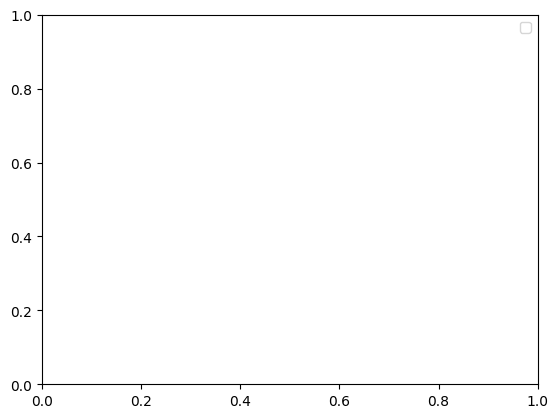

In [ ]:
import matplotlib.pylab as plt
for i, a in enumerate(r):
    plt.scatter(a[:, 0], a[:, 1], label=i)
plt.legend()
plt.show()


In [36]:
data_loader = {
    "train": train_loader,
    "val": test_loader,
    "test": test_loader,
}

dataset_sizes = {
    "train": len(train_dataset),
    "val": len(test_dataset),
    "test": len(test_dataset),
}


In [37]:
from train import train

model/state-ResNet18-optimizer-SGD-loss-CrossEntropyLoss.pth Not exist


### BETTER NET STATE ###
[345s] Epoch 1 loss : 1.65168184 acc: 40.53 val: 1.33252652 acc: 51.75%


### BETTER NET STATE ###
[370s] Epoch 2 loss : 1.27382933 acc: 54.73 val: 1.23314913 acc: 55.67%


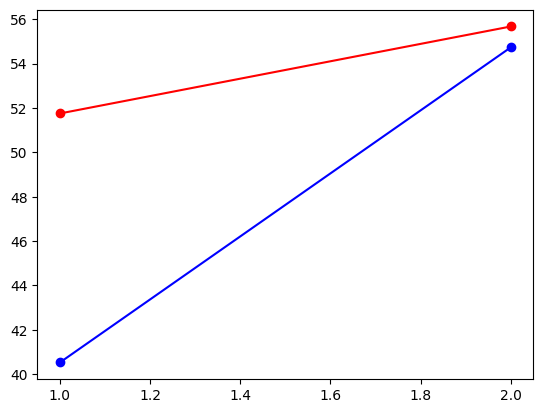

In [41]:
train(model, criterion, optimizer, data_loader, dataset_sizes, epochs=2)